<a href="https://colab.research.google.com/github/EnoshVechalapu/PlayStore-review-analysis/blob/main/PlayStoreReviewAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Play Store Review Analysis

**In this project, we are fining tuning BERT for sentiment analysis**

We will
* Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
* Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
* Evaluate the model on test data
* Predict sentiment on raw text

Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from transformers import BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Exploration

We'll load the Play Store app reviews dataset

In [2]:
df = pd.read_csv("/content/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [3]:
df.shape

(12495, 12)

In [4]:
df.isnull().sum()

reviewId                   0
userName                   0
userImage                  0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2162
at                         0
replyContent            6677
repliedAt               6677
sortOrder                  0
appId                      0
dtype: int64

In [5]:
df.dropna(inplace=True)

In [6]:
df.isnull().sum()

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
sortOrder               0
appId                   0
dtype: int64

In [7]:
df.shape

(4632, 12)

In [8]:
df.describe()

,score,thumbsUpCount
count,4632.000000,4632.000000
mean,2.724525,4.407383
std,1.341858,16.554252
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,4.000000,2.000000
max,5.000000,290.000000


## We're going to convert the dataset into negative, neutral and positive sentiment:

Negative (Score: 1-2)

Positive (Score: 4-5)

Neutral (Score: 3)


In [9]:
df["score"].value_counts()

score
1    1135
2    1039
3     964
4     955
5     539
Name: count, dtype: int64

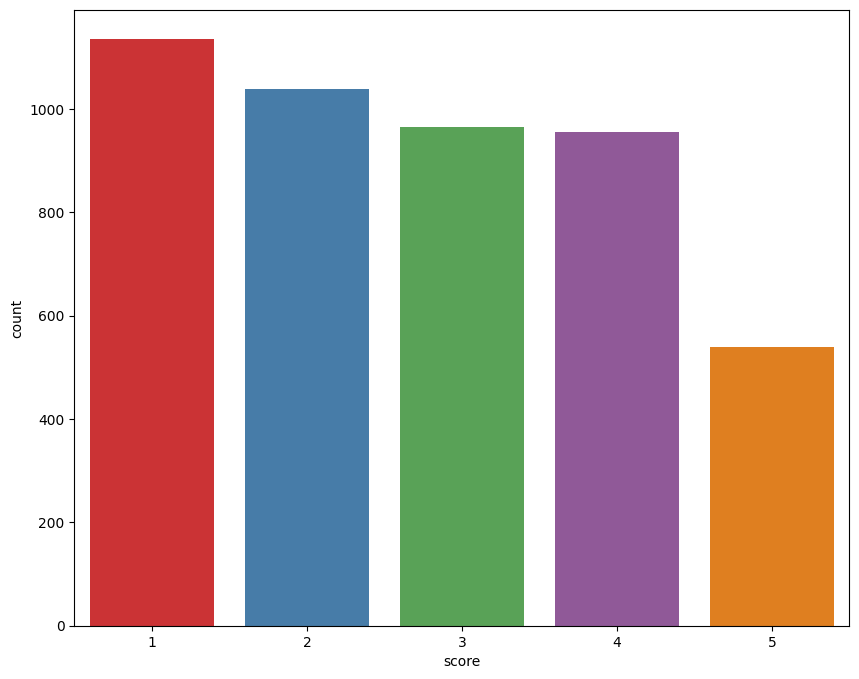

In [10]:
plt.figure(figsize=(10,8))
sns.countplot(x="score",data=df,palette="Set1")
plt.show()

In [11]:
def map_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    elif score in [4, 5]:
        return 'Positive'
    else:
        return 'Unknown'
df['sentiment'] = df.score.apply(map_sentiment)

In [12]:
df["sentiment"].value_counts()

sentiment
Negative    2174
Positive    1494
Neutral      964
Name: count, dtype: int64

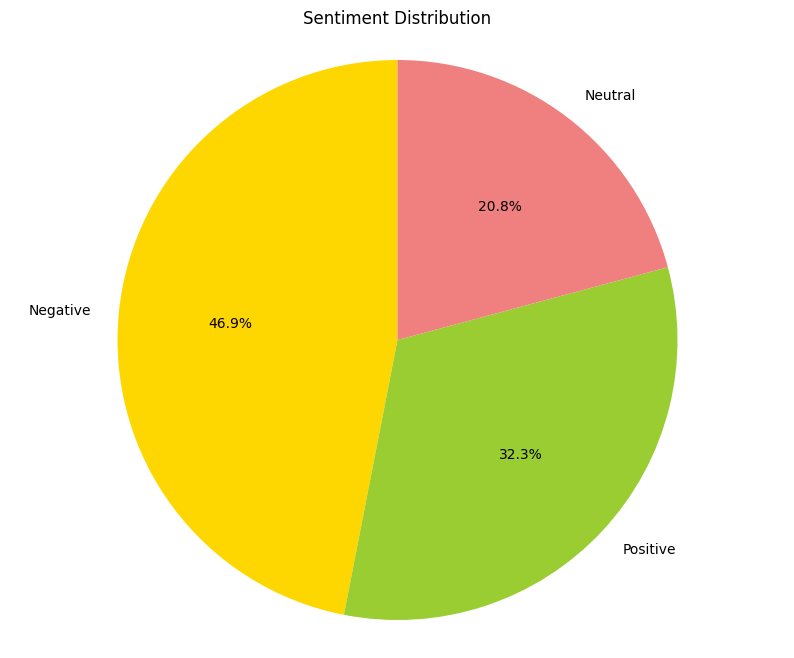

In [13]:
plt.figure(figsize=(10,8))
labels = df["sentiment"].value_counts().index
sizes = df["sentiment"].value_counts().values
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()

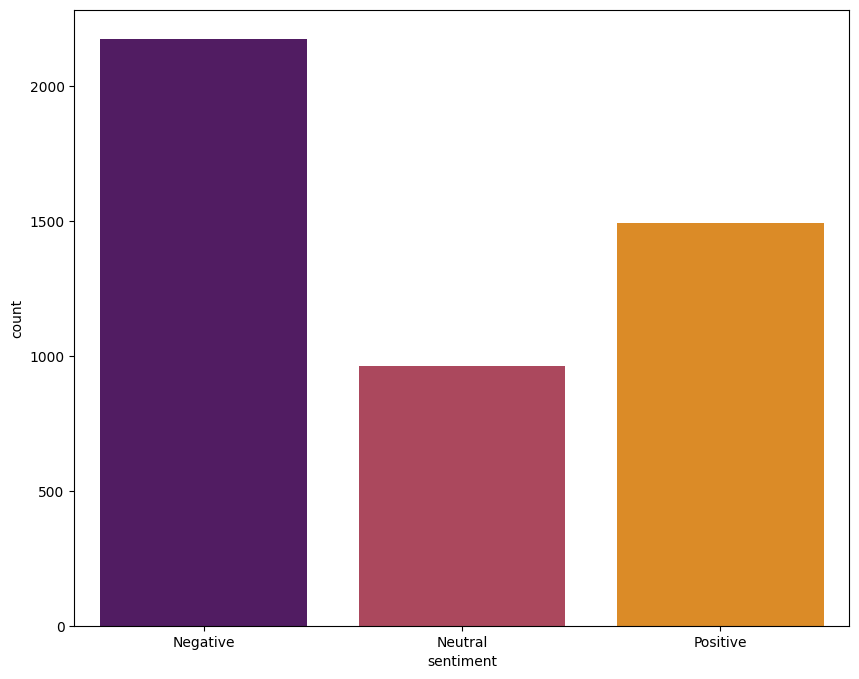

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(x="sentiment",data=df,palette="inferno")
plt.show()

In [15]:
df.drop(columns=["reviewId","userName","userImage","repliedAt","at"],axis=1,inplace=True)

In [16]:
df["thumbsUpCount"].value_counts()

thumbsUpCount
0      2693
1       638
2       295
3       179
4       110
       ... 
178       1
72        1
77        1
290       1
142       1
Name: count, Length: 113, dtype: int64

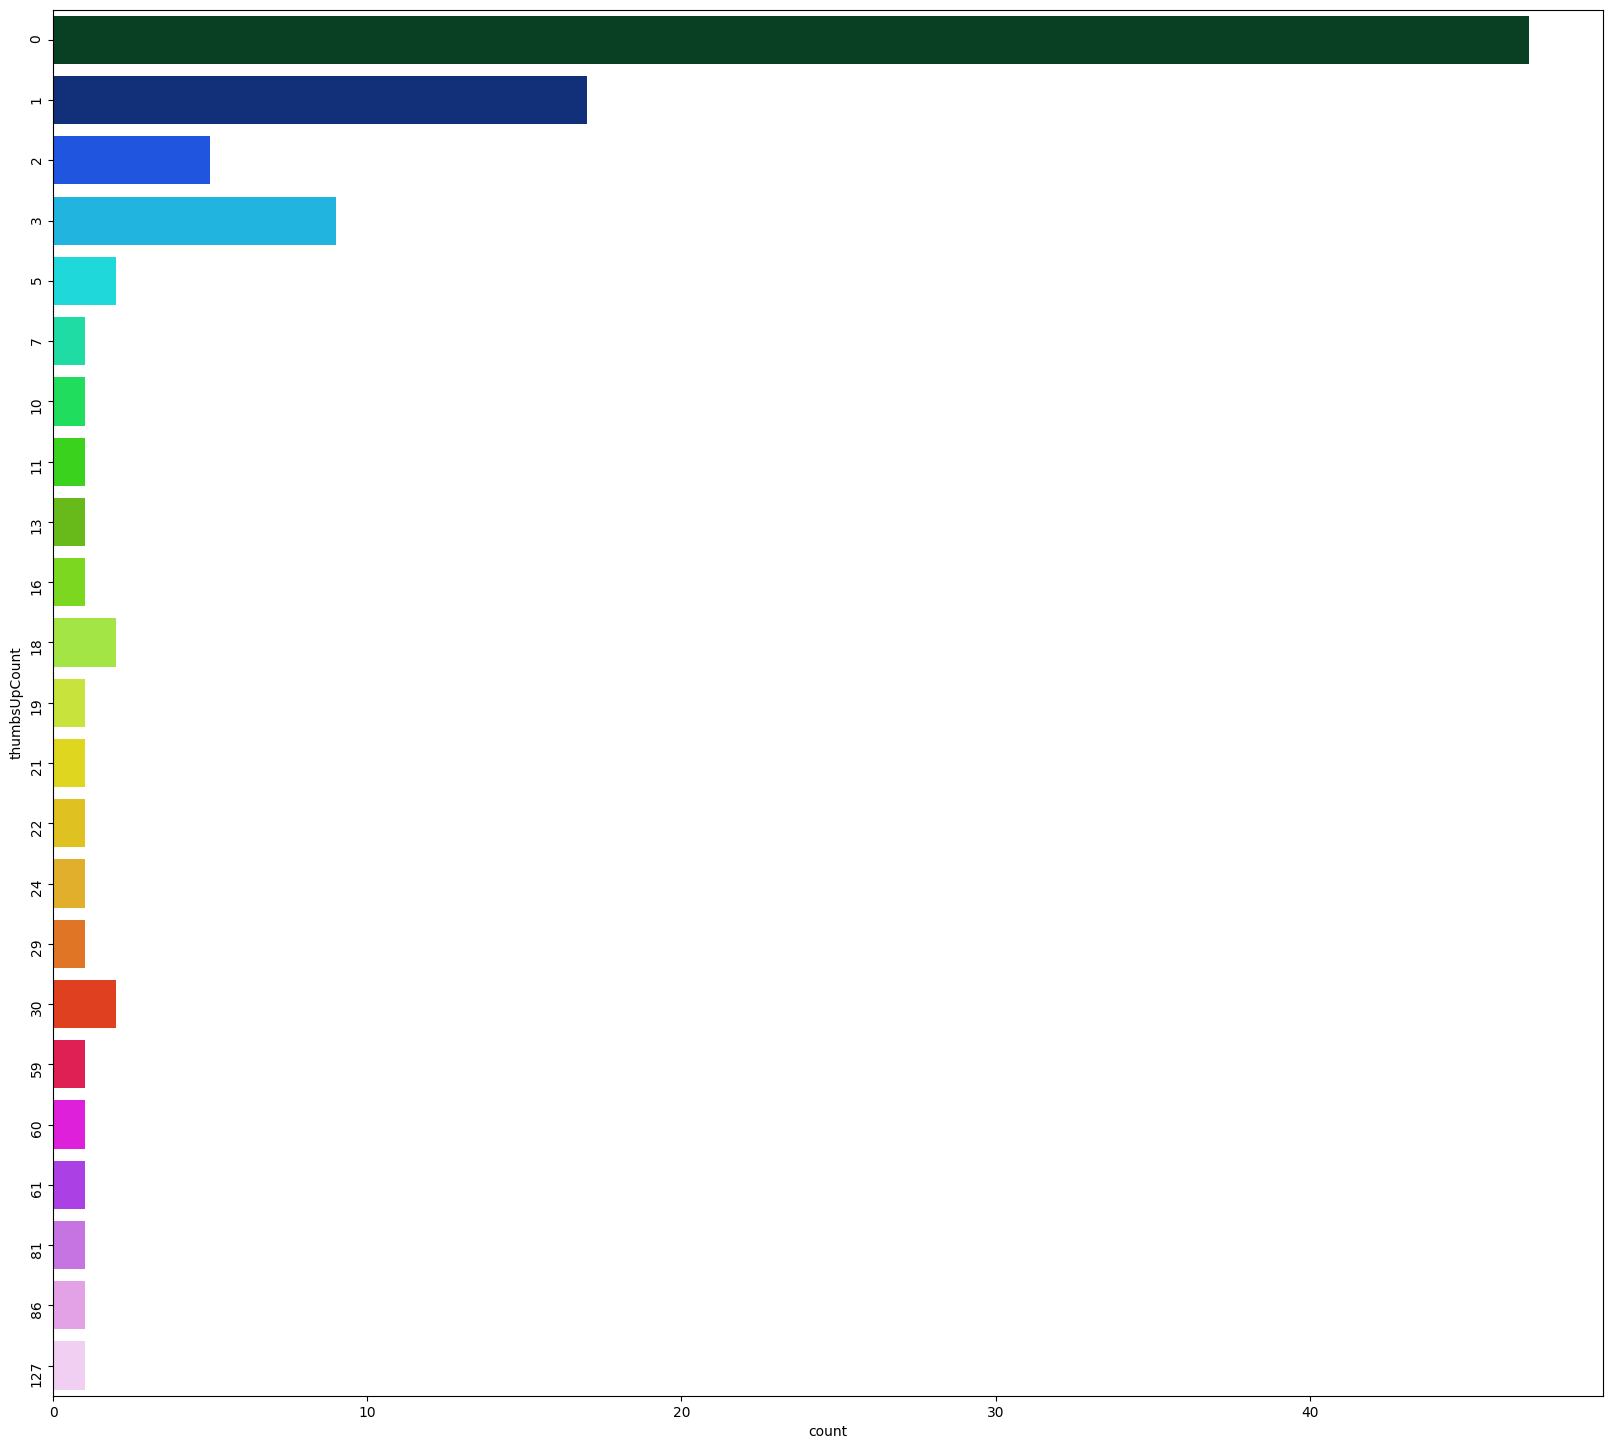

In [17]:
plt.figure(figsize=(20,18))
sns.countplot(y="thumbsUpCount",data=df[: 100],palette="gist_ncar")
plt.yticks(rotation=90)
plt.show()

In [18]:
df["sortOrder"].value_counts()

sortOrder
newest    4632
Name: count, dtype: int64

In [19]:
df["appId"].value_counts()

appId
com.tasks.android                555
com.gmail.jmartindev.timetune    526
com.anydo                        518
com.appgenix.bizcal              511
com.habitrpg.android.habitica    483
com.levor.liferpgtasks           478
cc.forestapp                     380
com.ticktick.task                276
com.todoist                      253
com.habitnow                     251
prox.lab.calclock                224
com.microsoft.todos              117
com.artfulagenda.app              47
com.appxy.planner                 11
com.oristats.habitbull             2
Name: count, dtype: int64

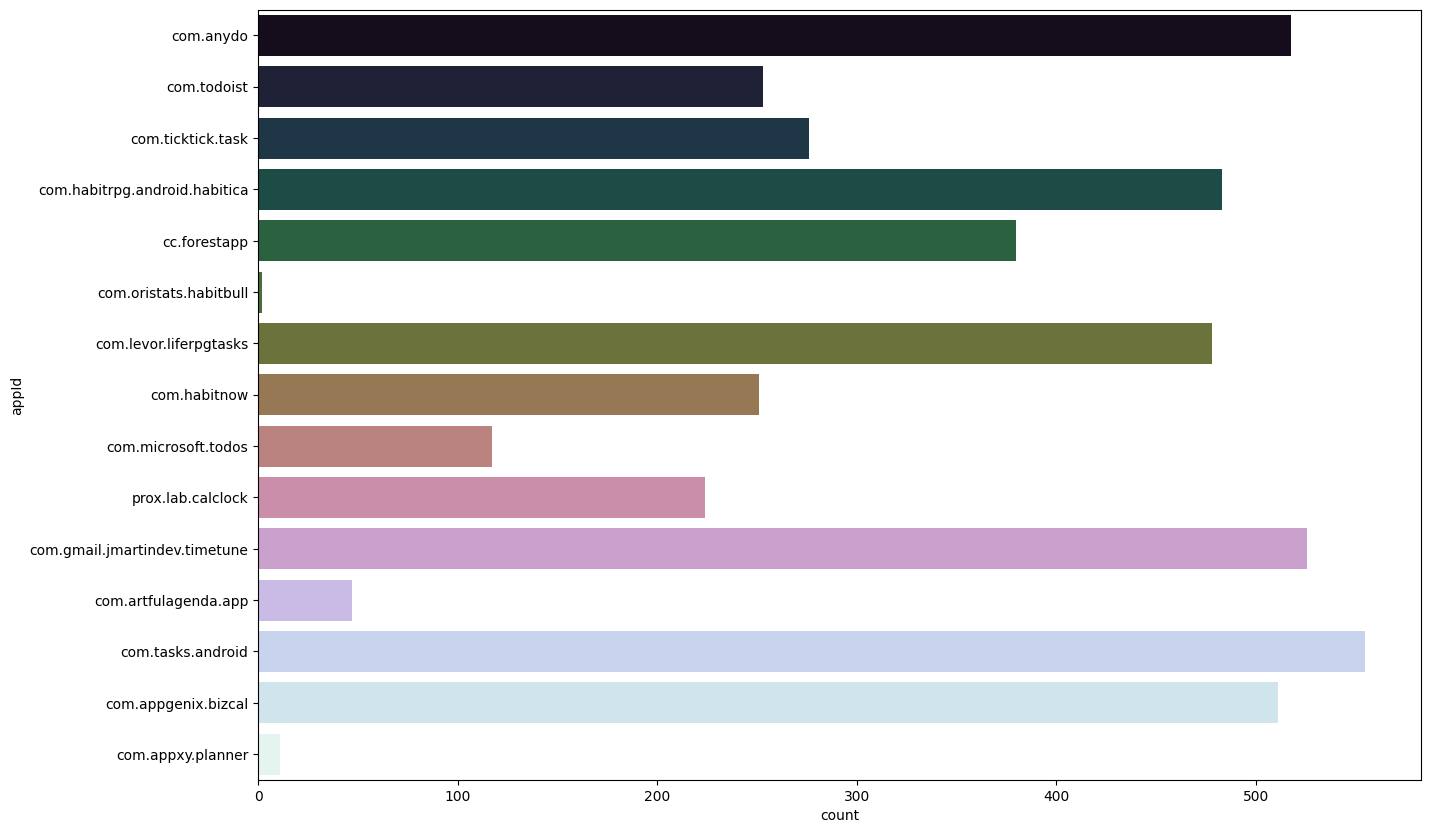

In [20]:
plt.figure(figsize=(15,10))
sns.countplot(y="appId",data=df,palette="cubehelix")
plt.show()

In [22]:
df.drop(columns=["score","thumbsUpCount","reviewCreatedVersion","sortOrder","appId"],axis=1,inplace=True)

In [23]:
df.rename(columns={'sentiment': 'label'}, inplace=True)

In [24]:
df["text"]=df["content"]+""+df["replyContent"]

In [25]:
df.drop(columns=["content","replyContent"],axis=1,inplace=True)

In [26]:
df=df[["text","label"]]

In [27]:
avg_len=df["text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 391.17


In [28]:
df.head()

,text,label
5,It has changed how I viewed my different lists...,Negative
6,I'm only looking for a grocery list app but ev...,Negative
7,"Reset my free trial, new phone I'd like to see...",Negative
8,How do to stop monthly payment because i don't...,Negative
9,I complain about not crashes and it was immedi...,Negative


In [29]:
df["label"]=df["label"].replace({"Negative":0,"Positive":1,"Neutral":2})
class_names=["Negative","Positive","Neutral"]

In [30]:
df.head()

,text,label
5,It has changed how I viewed my different lists...,0
6,I'm only looking for a grocery list app but ev...,0
7,"Reset my free trial, new phone I'd like to see...",0
8,How do to stop monthly payment because i don't...,0
9,I complain about not crashes and it was immedi...,0


## Data Preprocessing

In [31]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [32]:
token_length=[]
for txt in df.text:
    tokens=tokenizer.encode(txt,max_length=512)
    token_length.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [33]:
len(token_length)

4632

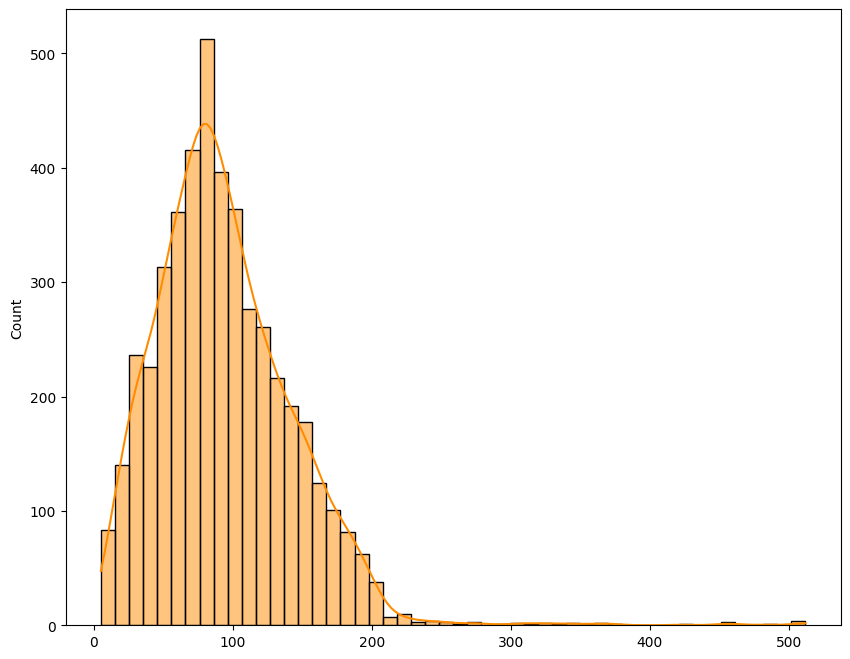

In [34]:
plt.figure(figsize=(10,8))
sns.histplot(token_length,color="darkorange",bins=50,kde=True)
plt.show()

Most of the reviews seem to contain less than 200 tokens, but we'll be on the safe side and choose a maximum length of 210

In [35]:
max_len=210

## Preparing the dataset

We have all building blocks required to create a PyTorch dataset.

In [36]:
class Review(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

Let's split the data:

In [37]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [38]:
def data_loader(df, tokenizer, max_len, batch_size):
    prepare_data = Review(reviews=df.text.to_numpy(),
                          labels=df.label.to_numpy(),
                          tokenizer=tokenizer,
                          max_len=max_len)

    return DataLoader(prepare_data, batch_size=batch_size, num_workers=0)

In [39]:
batch_size = 32
train_data_loader = data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = data_loader(df_test, tokenizer, max_len, batch_size)

In [40]:
data = next(iter(train_data_loader))
print(data.keys())



dict_keys(['review_text', 'input_ids', 'attention_mask', 'labels'])


In [58]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([32, 210])
torch.Size([32, 210])
torch.Size([32])


In [42]:
bert_model=BertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Sentiment Classification with BERT and Hugging Face

In [43]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):
    def __init__(self, number_class):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, number_class)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # The second element is the pooled output

        output = self.drop(pooled_output)
        return self.out(output)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)


In [44]:
print(model.bert.config)

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.41.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



## Training


Defining our optimizer

In [45]:
optimizer = optim.Adamax(model.parameters(), lr=0.00001)
epochs = 15
total_steps = len(train_data_loader) * epochs
criterion = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [46]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, example):
    model.train()
    losses = []
    prediction = 0

    train_epoch_iterator = tqdm(data_loader, desc="Training", leave=False)

    for i in train_epoch_iterator:
        input_ids = i["input_ids"].to(device)
        attention_mask = i["attention_mask"].to(device)
        labels = i["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, pred = torch.max(outputs, dim=1)

        loss = criterion(outputs, labels)
        prediction += torch.sum(pred == labels)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        train_epoch_iterator.set_postfix(loss=np.mean(losses))

    return prediction.double() / example, np.mean(losses)

In [47]:
def eval_model(model, data_loader, criterion, device, example):
    model.eval()
    losses = []
    prediction = 0

    val_epoch_iterator = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for x in val_epoch_iterator:
            input_ids = x["input_ids"].to(device)
            attention_mask = x["attention_mask"].to(device)
            labels = x["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = criterion(outputs, labels)
            prediction += torch.sum(preds == labels)
            losses.append(loss.item())
            val_epoch_iterator.set_postfix(loss=np.mean(losses))

    return prediction.double() / example, np.mean(losses)

The BERT authors have some recommendations for fine-tuning:

* Batch size: 16, 32

* Learning rate (Adam): 5e-5, 3e-5, 2e-5

* Number of epochs: 2, 3, 4

In [48]:
history = defaultdict(list)

for epoch in range(epochs):
    print(f"Epoch : {epoch+1}/{epochs}")
    print("-" * 15)

    train_acc, train_loss = train_epoch(model, train_data_loader, criterion, optimizer, device, scheduler, len(df_train))
    print(f"Train loss {train_loss} accuracy {train_acc}")

    val_acc, val_loss = eval_model(model, val_data_loader, criterion, device, len(df_val))
    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

Epoch : 1/15
---------------


Train loss 0.9612877656673563 accuracy 0.5751686909581646


Val loss 0.8387896219889323 accuracy 0.6522678185745141

Epoch : 2/15
---------------


Train loss 0.7909072966411196 accuracy 0.683940620782726


Val loss 0.7358363191286723 accuracy 0.6997840172786177

Epoch : 3/15
---------------


Train loss 0.7054067233513142 accuracy 0.7112010796221322


Val loss 0.7095020771026611 accuracy 0.7084233261339093

Epoch : 4/15
---------------


Train loss 0.6606459573938929 accuracy 0.7276653171390013


Val loss 0.6889605720837911 accuracy 0.7192224622030238

Epoch : 5/15
---------------


Train loss 0.6278292159068173 accuracy 0.7449392712550607


Val loss 0.6871427218119304 accuracy 0.7105831533477323

Epoch : 6/15
---------------


Train loss 0.5982913279841686 accuracy 0.7554655870445344


Val loss 0.6845607201258341 accuracy 0.7170626349892009

Epoch : 7/15
---------------


Train loss 0.5801788275611812 accuracy 0.7673414304993252


Val loss 0.6859134236971537 accuracy 0.7105831533477323

Epoch : 8/15
---------------


Train loss 0.558889746409038 accuracy 0.7773279352226721


Val loss 0.6952799956003824 accuracy 0.7127429805615552

Epoch : 9/15
---------------


Train loss 0.541710279368121 accuracy 0.7829959514170041


Val loss 0.6982253511746724 accuracy 0.7084233261339093

Epoch : 10/15
---------------


Train loss 0.5219180935929562 accuracy 0.7910931174089069


Val loss 0.6999062697092692 accuracy 0.7084233261339093

Epoch : 11/15
---------------


Train loss 0.5028305164185064 accuracy 0.7970310391363022


Val loss 0.7035353620847066 accuracy 0.7127429805615552

Epoch : 12/15
---------------


Train loss 0.4935800476834692 accuracy 0.8043184885290148


Val loss 0.7117018222808837 accuracy 0.7084233261339093

Epoch : 13/15
---------------


Train loss 0.4870893906416564 accuracy 0.8097165991902834


Val loss 0.7141511162122091 accuracy 0.7105831533477323

Epoch : 14/15
---------------


Train loss 0.4907723094882636 accuracy 0.8083670715249662


Val loss 0.7177688519159953 accuracy 0.7105831533477323

Epoch : 15/15
---------------


Train loss 0.4742168779003209 accuracy 0.8143049932523616


Val loss 0.7225860635439555 accuracy 0.7149028077753781



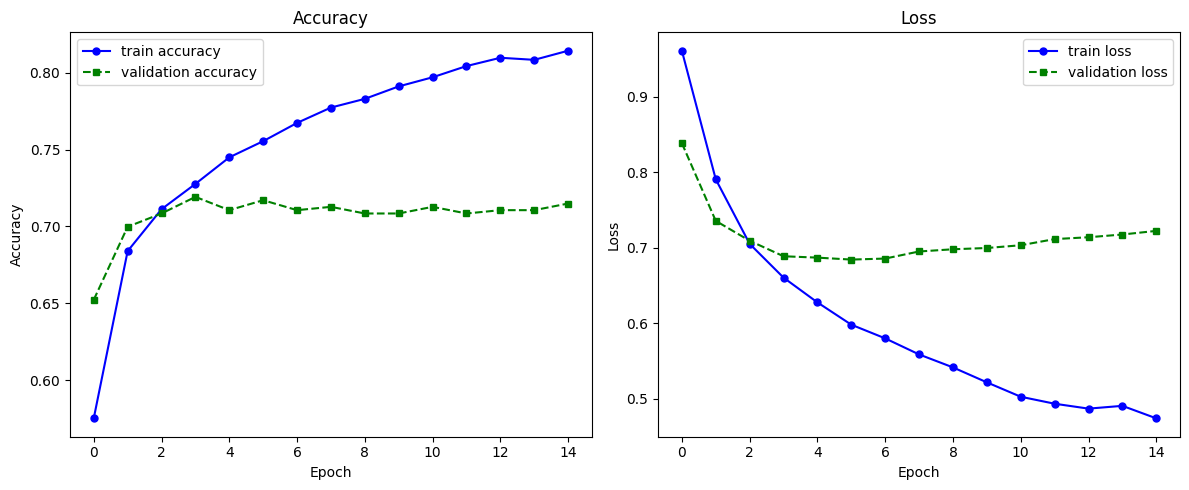

In [49]:

train_acc_np = np.array([t.cpu() for t in history['train_acc']])
val_acc_np = np.array([t.cpu() for t in history['val_acc']])
train_loss_np = np.array(history['train_loss'])
val_loss_np = np.array(history['val_loss'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(train_acc_np, label='train accuracy', linestyle='-', marker='o', color='blue', markersize=5)
ax1.plot(val_acc_np, label='validation accuracy', linestyle='--', marker='s', color='green', markersize=5)
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax2.plot(train_loss_np, label='train loss', linestyle='-', marker='o', color='blue', markersize=5)
ax2.plot(val_loss_np, label='validation loss', linestyle='--', marker='s', color='green', markersize=5)
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

# Test Model Performance

In [50]:
test_acc,_=eval_model(model,test_data_loader,criterion,device,len(df_test))
test_acc.item()

0.7241379310344828

In [51]:
def my_prediction(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []  # Initialize prediction_probs here
    real_values = []

    with torch.no_grad():
        for x in data_loader:
            texts = x["review_text"]
            input_ids = x["input_ids"].to(device)
            attention_mask = x["attention_mask"].to(device)
            labels = x["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)  # Use the initialized prediction_probs
            real_values.extend(labels)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

y_review_text, y_pred, y_proba, y_test = my_prediction(model, test_data_loader)

In [52]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.78      0.86      0.82       233
    Positive       0.80      0.79      0.80       140
     Neutral       0.37      0.27      0.31        91

    accuracy                           0.72       464
   macro avg       0.65      0.64      0.64       464
weighted avg       0.70      0.72      0.71       464



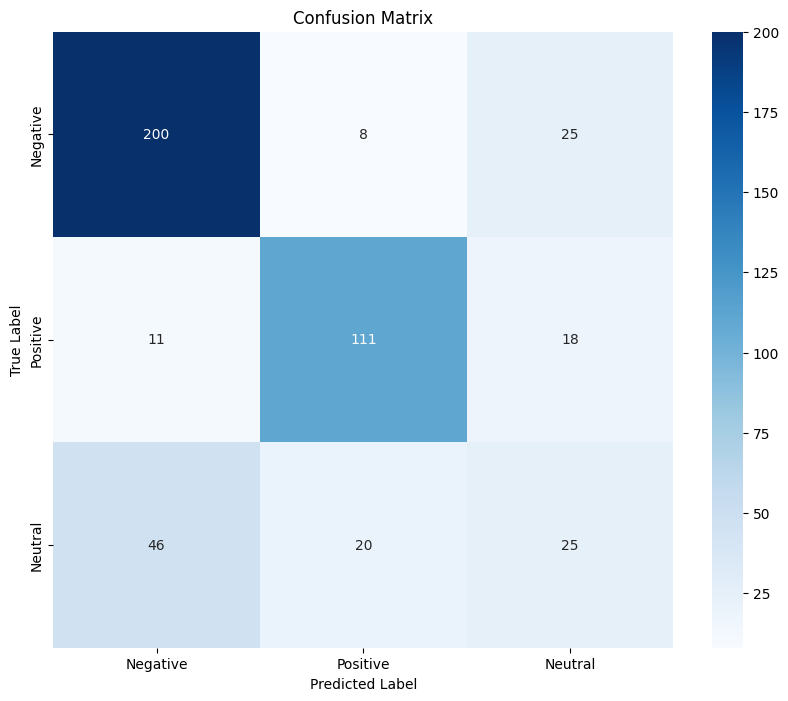

In [60]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=class_names,yticklabels=class_names,cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Let's have a look at an example from our test data

In [67]:
idx = 4

review_text = y_review_text[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_proba[idx]
})

In [68]:
import textwrap

In [69]:
print("\n".join(textwrap.wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

So close to being the perfect app. 2 things needed before I switch to
using it. #1. Add ability to edit and change habit status for previous
days. sometimes i don't have time or forget to update my habits on the
day of. #2. Ability to set first day of week for calendar (i prefer
Monday)Hi Michal. You can change habit status for previous days from
"My habits" section, or from the habit calendar, by touching on the
day you want to update. Thanks for your review! We are working to make
HabitNow a better app!

True sentiment: Positive


### Prediction On Custom Data:

We have to use the tokenizer to encode the text

In [72]:
test_text="I love completing my work using this app. Best app ever!!!"
check_custom_data=tokenizer.encode_plus(test_text,max_length=max_len,add_special_tokens=True,return_token_type_ids=False,
                                       pad_to_max_length=True,return_attention_mask=True,return_tensors="pt")
input_ids = check_custom_data['input_ids'].to(device)
attention_mask = check_custom_data['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print("Custom Text For Prediction ===> {}".format(test_text))

print("Prediction Result Is ===> {}".format(class_names[prediction]))


Custom Text For Prediction ===> I love completing my work using this app. Best app ever!!!
Prediction Result Is ===> Positive
